### Prepare for Using MMSegmentation

In [1]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.10/index.html
     |████████████████████████████████| 48.5 MB 5.9 MB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7335, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 7335 (delta 17), reused 31 (delta 9), pack-reused 7276
Receiving objects: 100% (7335/7335), 13.40 MiB | 40.24 MiB/s, done.
Resolving deltas: 100% (5426/5426), done.
/content/mmsegmentation


In [2]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [3]:
%cd mmsegmentation

[Errno 2] No such file or directory: 'mmsegmentation'
/content/mmsegmentation


In [4]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

### Run Inference with MMSeg trained weight

In [5]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = (
        'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed ',
        'windowpane', 'grass', 'cabinet', 'sidewalk', 'person', 'earth',
        'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car',
        'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug',
        'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe',
        'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column',
        'signboard', 'chest of drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path',
        'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door',
        'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffee table',
        'toilet', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove',
        'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar',
        'arcade machine', 'hovel', 'bus', 'towel', 'light', 'truck', 'tower',
        'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
        'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister',
        'escalator', 'ottoman', 'bottle', 'buffet', 'poster', 'stage', 'van',
        'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything',
        'swimming pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent',
        'bag', 'minibike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank',
        'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake',
        'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce',
        'vase', 'traffic light', 'tray', 'ashcan', 'fan', 'pier', 'crt screen',
        'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass',
        'clock', 'flag')

palette = [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]
            
# classes = ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
#             'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
#             'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
#             'bicycle')

# palette = [[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
#             [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
#             [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
#             [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
#             [0, 80, 100], [0, 0, 230], [119, 11, 32]]
classes = ('background', 'truck')
palette = [[0, 0, 0], [255, 0, 0]]
@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [8]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
#config_file = '/content/mmsegmentation/configs/convnext/upernet_convnext_large_fp16_640x640_160k_ade20k.py'
#checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/upernet_convnext_xlarge_fp16_640x640_160k_ade20k_20220226_080344-95fc38c2.pth'
#config_file = '/content/mmsegmentation/configs/convnext/upernet_convnext_xlarge_fp16_640x640_160k_ade20k.py'
config_file = '/content/mmsegmentation/configs/setr/setr_vit-large_naive_8x1_768x768_80k_cityscapes.py'
from mmcv import Config
!pip install mmcls
cfg = Config.fromfile(config_file)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577 kB 5.0 MB/s 


In [9]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
# cfg.norm_cfg = dict(type='BN', requires_grad=True)

# cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
# cfg.model.decode_head.num_classes = 5
# cfg.model.auxiliary_head.num_classes = 5

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[117.871, 115.512, 118.21], std=[45.079, 45.176, 42.465], to_rgb=True)
cfg.crop_size = (640, 640)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='Resize', img_scale=(2048, 640), ratio_range=(0.5, 1.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA/unlabel_images'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images'
cfg.data.train.ann_dir = 'pre_labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'images'
cfg.data.val.ann_dir = 'pre_labels'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'images'
cfg.data.test.ann_dir = 'pre_labels'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_10000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint'

cfg.runner.max_iteTrs = 200
cfg.log_config = log_config = dict(  # config to register logger hook
    interval=50,  # Interval to print the log
    hooks=[
        # dict(type='TensorboardLoggerHook')  # The Tensorboard logger is also supported
        dict(type='TextLoggerHook', by_epoch=False)
    ])

cfg.evaluation.interval = 1000
cfg.checkpoint_config.interval = 3000

cfg.runner = dict(type='IterBasedRunner', max_iters=10000)

# cfg.workflow = [('train', 2)]

# Set seed to facitate reproducing the result
cfg.device = 'cuda'
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

In [10]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

2022-06-22 04:18:03,435 - mmseg - INFO - Loaded 155 images


In [11]:
datasets[0]

### Model Test

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_10000.pth'
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda')  #cuda gpu 사용

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/iter_10000.pth


In [16]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from google.colab.patches import cv2_imshow
df = pd.read_csv('/content/drive/MyDrive/contour.csv')
d = os.listdir('/content/drive/MyDrive/SIA/images')
print('cuda' if torch.cuda.is_available() else 'cpu')
for i in tqdm(range(len(d))):
  #cls = df['class'][i]
  if d[i][0] == 'c':
    name = d[i]
    img = cv2.imread(f'/content/drive/MyDrive/SIA/images/{name}')
    #img = cv2.imread(f'/content/drive/MyDrive/SIA/unlabel_images/{name}.jpg')
    w, h = img.shape[:2]
    result = np.array(inference_segmentor(model_ckpt, img))

    img = model_ckpt.show_result(f'/content/drive/MyDrive/SIA/images/{name}', result, palette=palette, show=False, opacity=0.6)
    # result = np.reshape(result, (w,h))
    # result = np.where(result > 15, 0, result)
    # result = np.where(result < 13, 0, result)
    # result = np.stack((result,)*3, axis=-1)
    # img_gray = np.zeros((w, h, 3))
    # mask = np.where(result, np.array([0, 0, 255]), img_gray)
    
    # out = cv2.addWeighted(img, 0.6, mask, 0.4, 0, dtype = cv2.CV_32F)
    cv2.imwrite(f'/content/drive/MyDrive/SIA/setrr/{name}.jpg', img)

#     label, idx = submit(result)
#     df['prediction'][i] = idx
# df.to_csv('/content/drive/MyDrive/SIA/last.csv',index=False)

cuda


  0%|          | 0/156 [00:00<?, ?it/s]/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '
100%|██████████| 156/156 [00:17<00:00,  9.07it/s]


In [ ]:
# 76:boat 83:truck 80:folk 122 bus
def submit(result):
  k=-1
  a, b = np.unique(result,return_counts = True)
  if len(a) == 1:
    sh = result.shape
    w, h = sh[0], sh[1]
    return 'container_truck', f'{int(w*h/2)} 5'
  
  a, b = a[1:], b[1:]

  m = a[b.argmax()]
  label = 'container_truck'
  result = result.reshape(-1,)
  start = True
  ch = False
  idx = []
  cnt = 0
  for i in range(len(result)):
    if result[i] == m :
      cnt += 1
      if start:
        idx.append(str(i))
        start = False
        ch = True
    elif result[i] != m and ch:
      start = True
      ch = False
      idx.append(str(cnt))
      cnt = 0

  return label, ' '.join(idx)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SIA/hae.csv')
a = []
for i in range(len(df)):
  name = df['file_name'][i]
  img = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}.jpg')
  a.append(np.mean(img[:10][:10]))
print(min(a))

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
df = pd.read_csv('/content/drive/MyDrive/SIA/hae.csv')
df2 = pd.read_csv('/content/drive/MyDrive/semi_final3.csv')
a = []
j = 0
for i in range(len(df2)):
  if df2['class'][i][0] == 'c':
    name = df2['file_name'][i]
    img = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}')
    if np.mean(img[:10][:10]) >= 160 :
      if name[:-4] not in list(df['file_name']):
        print(name[:-4])

# 2SSZ4EgHnR
  #cv2.imwrite(f'/content/drive/MyDrive/SIA/hae/{i}.jpg', img)

aRI3KSkQXW


In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
df = pd.read_csv('/content/drive/MyDrive/SIA/sub_large2.csv')
labels = ('background', 'container_truck', 'forklift', 'reach_stacker', 'ship')
classes = []
index = []
names = []
j = 0
print('cuda' if torch.cuda.is_available() else 'cpu')
for i in tqdm(range(len(df))):
  j += 1
  cls = df['class'][i]
  name = df['file_name'][i]
  img = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}')

  result = np.array(inference_segmentor(model_ckpt, img))
  w, h = img.shape[:2]
  result = np.reshape(result, (w,h))

  label, idx = submit(result)
  classes.append(label)
  index.append(idx)
  names.append(i)
  if j % 1000 == 0:
    sub = pd.DataFrame({'file_name':names, 'class':classes, 'prediction':index})
    sub.to_csv(f'/content/drive/MyDrive/SIA/submission_{j}.csv', index=False)
    classes, index, names = [], [], []


sub = pd.DataFrame({'file_name':names, 'class':classes, 'prediction':index})
sub.to_csv(f'/content/drive/MyDrive/SIA/submission_{j}.csv', index=False)

show_result_pyplot(model_ckpt, img, result)

cuda


100%|██████████| 8409/8409 [1:41:12<00:00,  1.38it/s]


In [ ]:
import pandas as pd
df1 = pd.read_csv('/content/drive/MyDrive/SIA/submission_1000.csv')
df2 = pd.read_csv('/content/drive/MyDrive/SIA/submission_2000.csv')
df3 = pd.read_csv('/content/drive/MyDrive/SIA/submission_3000.csv')
df4 = pd.read_csv('/content/drive/MyDrive/SIA/submission_4000.csv')
df5 = pd.read_csv('/content/drive/MyDrive/SIA/submission_5000.csv')
df6 = pd.read_csv('/content/drive/MyDrive/SIA/submission_6000.csv')
df7 = pd.read_csv('/content/drive/MyDrive/SIA/submission_7000.csv')
df8 = pd.read_csv('/content/drive/MyDrive/SIA/submission_8000.csv')
df9 = pd.read_csv('/content/drive/MyDrive/SIA/submission_8409.csv')

file_names = list(df1['file_name']) + list(df2['file_name']) + list(df3['file_name']) + list(df4['file_name']) + list(df5['file_name']) + list(df6['file_name']) + list(df7['file_name']) + list(df8['file_name']) + list(df9['file_name'])
classes = list(df1['class']) + list(df2['class']) + list(df3['class']) + list(df4['class']) + list(df5['class']) + list(df6['class']) + list(df7['class']) + list(df8['class']) + list(df9['class'])
prediction = list(df1['prediction']) + list(df2['prediction']) + list(df3['prediction']) + list(df4['prediction']) + list(df5['prediction']) + list(df6['prediction']) + list(df7['prediction']) + list(df8['prediction']) + list(df9['prediction'])

df = pd.DataFrame({'file_name':file_names, 'class':classes, 'prediction':prediction})
df.to_csv('/content/drive/MyDrive/SIA/sub_large2.csv', index= False)

In [ ]:
from google.colab.patches import cv2_imshow

def addmask(name):
  classes = ('background', 'container_truck', 'forklift', 'reach_stacker', 'ship')
  palette = [[255, 255, 255], [0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 0, 255]]
  if name[0] == 'c':
    idx = 1
  elif name[0] == 'f':
    idx = 2
  elif name[0] == 'r':
    idx = 3
  else:
    idx = 4
  img1 = cv2.imread(f'/content/drive/MyDrive/SIA/unlabel_images/{name}.jpg')
  img2 = cv2.imread(f'/content/drive/MyDrive/SIA/unlabel_images_label/{name}.png')
  h, w, _ = img2.shape
  img_gray = np.zeros((h, w, 3))
  mask = np.where(img2, palette[idx], img_gray)
  
  out = cv2.addWeighted(img1, 0.6, mask, 0.4, 0, dtype = cv2.CV_32F)
  
  cv2.imwrite(f'/content/drive/MyDrive/SIA/unlabel_images_result/{name}.jpg', out)
names = os.listdir('/content/drive/MyDrive/SIA/unlabel_images_label')
for name in tqdm(names):  
  addmask(name[:-4])

100%|██████████| 1565/1565 [09:44<00:00,  2.68it/s]


In [ ]:
import os
import cv2
from tqdm import tqdm
def inference(path):
  img_names = os.listdir(path)
  for name in tqdm(img_names):
    img = cv2.imread(f'{path}/{name}')
    w, h = img.shape[:2]
    result = np.array(inference_segmentor(model_ckpt, img))
    result = np.reshape(result, (w, h, 1))
    cv2.imwrite(f'/content/drive/MyDrive/SIA/unlabel_images_label/{name[:-4]}.png', result)

inference('/content/drive/MyDrive/SIA/unlabel_images')

100%|██████████| 1565/1565 [22:15<00:00,  1.17it/s]


In [ ]:
def submit(result):
  k=-1
  a, b = np.unique(result,return_counts = True)
  if len(a) == 1:
    sh = result.shape
    w, h = sh[0], sh[1]
    return 'container_truck', f'{int(w*h/2)} 5'
  a, b = a[1:], b[1:]

  m = a[b.argmax()]
  #label = labels[m]
  label = 'ship'
  result = result.reshape(-1,)
  start = True
  ch = False
  idx = []
  cnt = 0
  for i in range(len(result)):
    if result[i] == m :
      cnt += 1
      if start:
        idx.append(str(i))
        start = False
        ch = True
    elif result[i] != m and ch:
      start = True
      ch = False
      idx.append(str(cnt))
      cnt = 0
  
  if result[-1] == m and idx[-1] != len(result)-1:
    idx.append(str(len(result)-1))

  return label, ' '.join(idx)

In [ ]:
import os
import cv2
import numpy as np
img = cv2.imread('/content/drive/MyDrive/SIA/RrXQwdjkFW.png', cv2.IMREAD_UNCHANGED)
_, idx = submit(img)
print(idx)
# 93903 9 94560 36 95217 45 95871 51 96528 57 97170 78 97830 81 98487 93 99147 96 99807 99 100467 99 101127 99 101787 102 102444 105 103104 108 103761 114 104418 123 105075 138 105651 6 105693 195 106302 21 106347 207 106944 273 107601 288 107895 18 108261 318 108921 324 109584 324 110244 327 110907 324 111567 321 112230 318 112896 309 113562 300 114237 282 114924 252 115605 231 116295 207 116976 192 117702 24 117780 12 117795 45 118458 42 119121 33 119790 9
# 111354 6 112074 9 112791 18 113508 27 114225 42 114927 66 115641 75 116361 75 117081 78 117801 81 118521 84 119238 93 119958 102 120675 108 121395 108 122112 111 122832 111 123552 114 124269 117 124932 18 124986 123 125583 33 125640 51 125703 129 126297 261 127017 267 127737 282 128457 291 129180 291 129903 297 130626 306 131346 312 132069 330 132789 336 133509 342 134232 342 134955 339 135684 330 136425 306 137166 282 137901 264 138636 243 139377 219 140112 198 140847 171 141591 90

31301 3 31520 12 31739 15 31957 17 32176 19 32390 26 32610 27 32829 31 33049 32 33269 33 33489 33 33709 33 33929 34 34148 35 34368 36 34587 38 34806 41 35025 46 35217 2 35231 65 35434 7 35449 69 35648 91 35867 96 35965 6 36087 106 36307 108 36528 108 36748 109 36969 108 37189 107 37410 106 37632 103 37854 100 38079 94 38308 84 38535 77 38765 69 38992 64 39234 8 39260 4 39265 15 39486 14 39707 11 39930 3


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


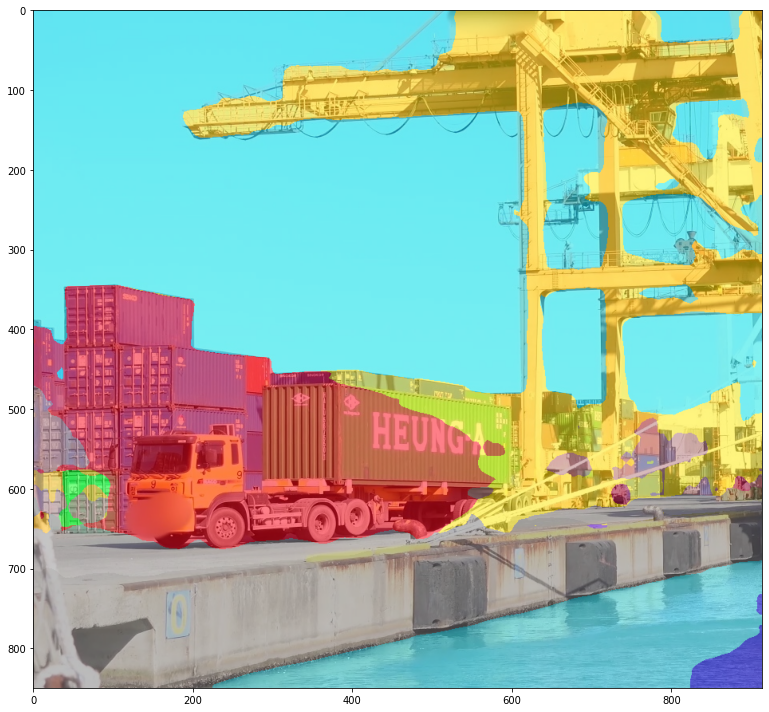

In [ ]:
from numpy.lib.index_tricks import index_exp
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import random
df = pd.read_csv('/content/drive/MyDrive/SIA/sub_large.csv')
dfc = pd.read_csv('/content/drive/MyDrive/SIA/sub_lg_c_sa.csv')
df7 = pd.read_csv('/content/drive/MyDrive/SIA/seg_sub.csv')
u2pl = pd.read_csv('/content/drive/MyDrive/SIA/enho.csv')
#dfl = pd.read_csv('/content/drive/MyDrive/SIA/test_label.csv')
# segformer vs convnext
# cnt = []
# for i in range(len(df)):
#   if df['class'][i] != df7['class'][i]:  
#     print(df['class'][i], df7['class'][i])

labels = ('background', 'container_truck', 'forklift', 'reach_stacker', 'ship')
# 픽셀을 이미지로 변환
def infe(path):
  img = cv2.imread(path)
  result = inference_segmentor(model_ckpt, img)

  # l, idx = submit(np.array(result))
  # sh = img.shape
  # h, w = sh[0], sh[1]
  # idx = idx.split(' ')

  # a = np.zeros(shape=(w*h))

  # for i in range(len(idx)):
  #   if i%2 == 0:
  #     for j in range(int(idx[i+1])):
  #       a[int(idx[i])+j] = 4
  # a = np.reshape(a, (1,h,w))
  #show_result_pyplot(model_ckpt, img, a)
  show_result_pyplot(model_ckpt, img, result)
infe('/content/drive/MyDrive/SIA/test/images/2SSZ4EgHnR.jpg')
#['2SSZ4EgHnR.jpg', '2iSq2K9t0h.jpg', '31m47IZl9E.jpg', '3Gs0xIWzkE.jpg', '3uWYK7l0KG.jpg', 
#[339, 371, 413, 446, 529, 605, 860, 879, 1050, 1091, 1099, 1110, 1195, 1448, 1490, 1546, 1572, 1583, 1693, 1696, 1785, 1786, 1812, 1846, 1993, 2047, 2187, 2204, 2249, 2250, 2421, 2535, 2712, 2879, 2880, 2932, 3068, 3103, 3235, 3247, 3256, 3365, 3448, 3499, 3685, 3704, 3743, 3934, 3939, 3967, 3993, 4168, 4217, 4259, 4432, 4677, 4692, 4849, 4931, 5022, 5060, 5097, 5114, 5280, 5385, 5641, 5675, 5726, 5903, 5929, 5948, 6040, 6262, 6311, 6364, 6586, 6601, 6917, 7172, 7197, 7247, 7368, 7779, 7972, 8049, 8114, 8226, 8246, 8255, 8281]
def showP2I(ddf, index):
  name = ddf['file_name'][index]
  idx = ddf['prediction'][index].split(' ')
  cls = ddf['class'][index]
  img = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}')
  #img = cv2.imread(f'/content/drive/MyDrive/SIA/images/{name}')

  sh = img.shape
  h, w = sh[0], sh[1]

  a = np.zeros(shape=(w*h), dtype='uint8')
  for i in range(len(idx)):
    if i%2 == 0:
      for j in range(int(idx[i+1])):
        a[int(idx[i])+j] = 4
  a = np.reshape(a,(h, w))
  a = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB)
  # a = np.array([a,a,a])
  # a = np.reshape(a,(h,w,3))
  palette = [[255, 255, 255], [0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 0, 255]]
  clss = 0
  if cls[0] == 'c': clss = 1
  elif cls[0] == 'f': clss = 2
  elif cls[0] == 'r': clss = 3
  elif cls[0] == 's': clss = 4

  img_gray = np.zeros((h, w, 3,),dtype='uint8')
  color = np.array([palette[clss]],dtype='uint8')
  mask = np.where(a, np.array(palette[clss]), img_gray)
  mask = np.array(mask,dtype='uint8')
  out = cv2.addWeighted(img, 0.6, mask, 0.4, 0)
  cv2.imwrite(f'/content/drive/MyDrive/SIA/train_2_result/{name[:-4]}.png', out)

  #return out
# for i in tqdm(range(len(df))):
#   showP2I(dfc,i)


# fig, axes = plt.subplots(5, 2, figsize=(20, 60)) # 4개의 ax를 가진 하나의 figure 생성

# idx = 0
# for i in range(5):
#     for j in range(2):
#         # diff = [1448, 2026, 2249, 2421, 2879, 2932, 3499, 5948, 7467, 7994]
#         #m_img = showP2I(dfc, random.randint(0,134))
#         m_img = showP2I(dfc, i*2 + j)
#         axes[i, j].imshow(m_img)

# showP2I(df7, 8281)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm
import pandas as pd
import os
import cv2
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/SIA/sample.csv')
def contour_remove_pixel(ddf):
  for index in tqdm(range(len(ddf))):
    name = ddf['file_name'][index]
    pixel = ddf['prediction'][index].split(' ')
    ccc = ddf['class'][index]
    img1 = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}')

    if ccc[0] == 'c': cls = 1
    elif ccc[0] == 'f': cls = 2
    elif ccc[0] == 'r': cls = 3
    elif ccc[0] == 's': cls = 4
    
    sh = img1.shape
    h, w = sh[0], sh[1]
    img2 = np.zeros(shape=(w*h), dtype='uint8')

    for i in range(len(pixel)):
      if i%2 == 0:
        for j in range(int(pixel[i+1])):
          img2[int(pixel[i])+j] = cls

    img2 = np.reshape(img2, (h,w))

    # img2 = cv2.cvtColor(img2, cv2.)

    ret, img_binary = cv2.threshold(img2, 0, 255, 0)
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
      continue

    m = 0
    idx = 0
    boat_area = []
    for i in range(len(contours)):
      area = cv2.contourArea(contours[i])
      if area > m:
        m = area
        idx = i
      boat_area.append(area)
    
    if cls == 4:
      boat_ship = []
      for i in contours:
        mn = w
        for j in i:
          if mn > j[0][1]:
            mn = j[0][1]
        boat_ship.append(mn)
      mmm = 0
      for i in range(len(boat_ship)):
        if boat_area[i]*2.5 > m:
          if mmm < boat_ship[i]:
            mmm = boat_ship[i]
            idx = i


    mask = np.zeros(img1.shape[:2], dtype=img2.dtype)
    cv2.drawContours(mask, [contours[idx]], 0, (255), -1)
    result = cv2.bitwise_and(img2,img2, mask= mask)
    #cv2.drawContours(result, [contours[idx]], 0, (255, 0, 0), 3)
    result = np.reshape(result,(1, h, w))
    lab, ch1 = submit(result)
    ddf['prediction'][index] = ch1

    #show_result_pyplot(model_ckpt, img1, result)
    #cv2_imshow(result)
  ddf.to_csv('/content/drive/MyDrive/SIA/sub_lg_c_sa.csv', index=False)

# contour_remove_pixel(df)


from google.colab.patches import cv2_imshow

def contour_remove_png(path):
  img1 = cv2.imread(f'/content/drive/MyDrive/SIA/unlabel_images_label/{path}.png', cv2.IMREAD_COLOR)
  img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  ret, img_binary = cv2.threshold(img2, 0, 255, 0)
  w, h = img1.shape[:2]
  contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  
  m = 0
  idx = 0
  for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area > m:
      m = area
      idx = i
  if path == 'ship_FwUur52oht':
    idx = 0
  print(img1.dtype)
  mask = np.zeros(img2.shape[:2], dtype=img1.dtype)
  cv2.drawContours(mask, [contours[idx]], 0, (255), -1)
  result = cv2.bitwise_and(img1,img1, mask= mask)
  
  a, b = np.unique(result,return_counts=True)
  a, b = a[1:], b[1:]
  ma = a[b.argmax()]

  result = np.where(result !=0, [ma,ma,ma],[0,0,0])
  result = np.reshape(result, (3,w,h))
  result = result[0]
  #result = cv2.cvtColor(result, cv2.COLOR_GRAYSCALE)
  # print(result.shape)
  # return
  cv2.imwrite(f'/content/drive/MyDrive/SIA/pre_labels/{path}.png',result)
  #cv2_imshow(result)
names = os.listdir('/content/drive/MyDrive/SIA/before_train')
# print(names)
def asd(path):
  img = cv2.imread(f'/content/drive/MyDrive/SIA/unlabel_images/{path}.jpg')
  cv2.imwrite(f'/content/drive/MyDrive/SIA/images/{path}.jpg', img)
for name in names:
  contour_remove_png(name[:-4])
  # print(name[:-4])
  # asd(name[:-4])

def ShowSpecificLabel(ddf, label):
  for index in range(len(ddf)):
    if ddf['class'][index] == label:
        name = ddf['file_name'][index]
        idx = ddf['prediction'][index].split(' ')
        img = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}')
        
        sh = img.shape
        w, h = sh[0], sh[1]
        a = np.zeros(shape=(w*h))
        for i in range(len(idx)):
          if i%2 == 0:
            for j in range(int(idx[i+1])):
              a[int(idx[i])+j] = 4
        a = np.reshape(a, (1,w,h))
        show_result_pyplot(model_ckpt, img, a)
# ShowSpecificLabel(df7, 'reach_stacker')
# for i in full:
#   showP2I(df7, i)
#11 20 24 26 27 33 57 -3 -5

In [ ]:
import os
from tqdm import tqdm
import cv2
def addmask(name):
  palette = [[255, 255, 255], [0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 0, 255]]
  
  img1 = cv2.imread(f'/content/drive/MyDrive/SIA/images/{name}.jpg')
  img2 = cv2.imread(f'/content/drive/MyDrive/SIA/labels/{name}.png')


  h, w, _ = img2.shape
  img_gray = np.zeros((h, w, 3))
  mask = np.where(img2, palette[4], img_gray)
  
  out = cv2.addWeighted(img1, 0.6, mask, 0.4, 0, dtype = cv2.CV_32F)
  
  cv2.imwrite(f'/content/drive/MyDrive/SIA/bitwise_result/{name}.jpg', out)
names = os.listdir('/content/drive/MyDrive/SIA/bitwise_large2')
for name in tqdm(names):  
  addmask(name[:-4])

100%|██████████| 135/135 [00:40<00:00,  3.33it/s]


In [ ]:
import os
import cv2
import numpy as np
def make_predata():
  a = os.listdir('/content/drive/MyDrive/SIA/labels')
  for name in a:
    img = cv2.imread(f'/content/drive/MyDrive/SIA/labels/{name}', cv2.IMREAD_GRAYSCALE)
    if name[0] == 'c': number = 83
    elif name[0] == 'f': number = 80
    elif name[0] == 'r': number = 122
    elif name[0] == 's': number = 76
    
    img = np.where(img != 0, number, 0)
    print(img.shape, img.dtype)
    break
    cv2.imwrite(f'/content/drive/MyDrive/SIA/pre_labels2/{name}', img)
make_predata()

(2160, 2224) int64


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SIA/sub_large2.csv')

def infe(df, i):
  name = df['file_name'][i]
  pixel = df['prediction'][i]
  pixel = pixel.split(' ')
  img = cv2.imread(f'/content/drive/MyDrive/SIA/test/images/{name}')
  
  sh = img.shape
  h, w = sh[0], sh[1]

  a = np.zeros(shape=(w*h))

  for i in range(len(pixel)):
    if i%2 == 0:
      for j in range(int(pixel[i+1])):
        a[int(pixel[i])+j] = 76
  a = np.reshape(a, (h,w))
  cv2.imwrite(f'/content/drive/MyDrive/SIA/large2/{name[:-4]}.png', a)
for i in tqdm(range(len(df))):
  if df['class'][i] == 'ship':
    infe(df, i)

100%|██████████| 8409/8409 [01:36<00:00, 87.24it/s]


In [ ]:
from google.colab.patches import cv2_imshow

data = os.listdir('/content/drive/MyDrive/SIA/xlarge')
for name in tqdm(data):
  img = cv2.imread(f'/content/drive/MyDrive/SIA/xlarge/{name}', cv2.IMREAD_UNCHANGED )
  # img = np.where(img == 76, 255 , img)
  # img = np.where(img == 103, 255, img)
  # img = np.where(img == 34, 255, img)
  # img = np.where(img == 20, 255, img)
  # img = np.where(img == 4, 255, img)
  # img = np.where(img != 255, 0, img)
  img = np.where(img == 3, 0, img)
  img = np.where(img == 26, 0, img)
  img2 = cv2.imread(f'/content/drive/MyDrive/SIA/large2/{name}',cv2.IMREAD_UNCHANGED )
  img2 = np.where(img2 == 76, 255 , img2)
  
  result = cv2.bitwise_and(img,img2)

  cv2.imwrite(f'/content/drive/MyDrive/SIA/bitwise_1/{name}', result)


100%|██████████| 7840/7840 [1:32:37<00:00,  1.41it/s]


  0%|          | 0/7840 [00:00<?, ?it/s]

[  0   1   4   6  13  25  26  34 140]


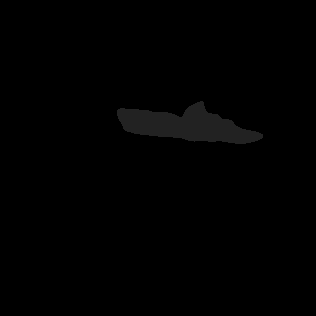

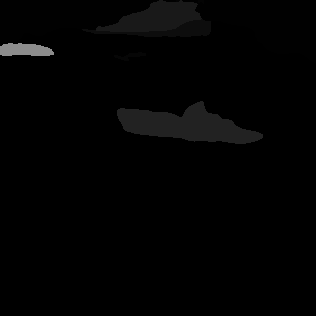

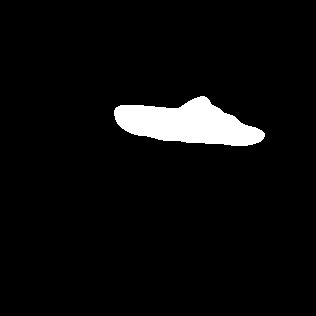

100%|██████████| 7840/7840 [00:00<00:00, 67171.79it/s]


In [ ]:
import os
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import cv2
import numpy as np
data = os.listdir('/content/drive/MyDrive/SIA/xlarge')
for name in tqdm(data):
  if name == 'PDZoQ13Cmk.png':
    img = cv2.imread(f'/content/drive/MyDrive/SIA/xlarge/{name}', cv2.IMREAD_UNCHANGED )
    print(np.unique(img))
    #img = np.where(img == 34, 255, img)
    img = np.where(img == 26, 0 , img)
    # img = np.where(img == 103, 255, img)
    # img = np.where(img == 34, 255, img)
    # img = np.where(img != 255, 0, img)
    img2 = cv2.imread(f'/content/drive/MyDrive/SIA/large2/{name}',cv2.IMREAD_UNCHANGED )
    img2 = np.where(img2 == 76, 255 , img2)
    result = cv2.bitwise_and(img2,img)
    cv2_imshow(result)
    cv2_imshow(img)
    cv2_imshow(img2)

In [ ]:
# data = os.listdir('/content/drive/MyDrive/SIA/xlarge')
# print(len(data))
# data = os.listdir('/content/drive/MyDrive/SIA/bitwise_1')
# print(len(data))
# import pandas as pd
# a = pd.read_csv('/content/drive/MyDrive/SIA/sub_large.csv')
# b = a['class']
# print(np.unique(b,return_counts=True))
# print(136+314+119+7840)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
data = os.listdir('/content/drive/MyDrive/SIA/bitwise_1')
from tqdm import tqdm
import cv2
import numpy as np
for name in tqdm(data):
  # img = cv2.imread(f'/content/drive/MyDrive/SIA/bitwise_1/{name}', cv2.IMREAD_UNCHANGED )
  #HlUtCYbffp
  img = cv2.imread(f'/content/drive/MyDrive/SIA/bitwise_1/RrXQwdjkFW.png', cv2.IMREAD_UNCHANGED )
  w, h = img.shape[:2]
  ret, img_binary = cv2.threshold(img, 0, 255, 0)
  contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours) == 0:
    print(name)
    continue

  m = 0
  idx = 0
  boat_area = []
  for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area > m:
      m = area
      idx = i
    boat_area.append(area)
  

  boat_ship = []
  for i in contours:
    mn = w
    for j in i:
      if mn > j[0][1]:
        mn = j[0][1]
    boat_ship.append(mn)
  mmm = 0
  for i in range(len(boat_ship)):
    if boat_area[i]*6.2 > m:
      if mmm < boat_ship[i]:
        mmm = boat_ship[i]
        idx = i

  mask = np.zeros(img.shape[:2], dtype=img.dtype)
  cv2.drawContours(mask, [contours[idx]], 0, (255), -1)
  result = cv2.bitwise_and(img,img, mask= mask)
  result = np.reshape(result, img.shape[:2])
  #cv2.imwrite(f'/content/drive/MyDrive/SIA/{name}', result)
  cv2.imwrite(f'/content/drive/MyDrive/SIA/RrXQwdjkFW.png', result)
  print(boat_area)
  break
  




  0%|          | 0/7840 [00:00<?, ?it/s]

[2117.5, 36.5, 2.0, 88.0, 49.5, 13119.0]


  0%|          | 0/7869 [00:00<?, ?it/s]

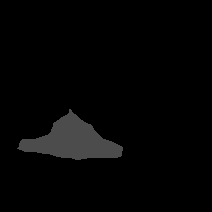

100%|██████████| 7869/7869 [00:00<00:00, 1082449.84it/s]


In [ ]:
data = os.listdir('/content/drive/MyDrive/SIA/bitwise_large2')
for name in tqdm(data):
  if name == '0G79D1tJj3.png':
    img = cv2.imread(f'/content/drive/MyDrive/SIA/bitwise_large2/{name}', cv2.IMREAD_UNCHANGED )

    w, h = img.shape[:2]
    ret, img_binary = cv2.threshold(img, 0, 255, 0)
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
      print(name)
      continue

    m = 0
    idx = 0
    boat_area = []
    for i in range(len(contours)):
      area = cv2.contourArea(contours[i])
      if area > m:
        m = area
        idx = i
      boat_area.append(area)
    
    boat_ship = []
    for i in contours:
      mn = w
      for j in i:
        if mn > j[0][1]:
          mn = j[0][1]
      boat_ship.append(mn)
    mmm = 0
    for i in range(len(boat_ship)):
      if boat_area[i]*3 > m:
        if mmm < boat_ship[i]:
          mmm = boat_ship[i]
          idx = i

    mask = np.zeros(img.shape[:2], dtype=img.dtype)
    cv2.drawContours(mask, [contours[idx]], 0, (255), -1)
    result = cv2.bitwise_and(img,img, mask= mask)
    result = np.reshape(result, img.shape[:2])
    cv2_imshow(result)
  




In [ ]:
def submit2(result):
  label = 'ship'

  result = result.reshape(-1,)
  start = True
  ch = False
  idx = []
  cnt = 0
  for i in range(len(result)):
    if result[i] != 0 :
      cnt += 1
      if start:
        idx.append(str(i))
        start = False
        ch = True
    elif result[i] == 0 and ch:
      start = True
      ch = False
      idx.append(str(cnt))
      cnt = 0
  
  if result[-1] != 0 and start == False:
    idx.append(str(len(result)-1 - int(idx[-1])))

  return label, ' '.join(idx)

In [ ]:
import os
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/SIA/truck.csv')
df2 = os.listdir('/content/drive/MyDrive/SIA/bitwise_2')
from tqdm import tqdm
import cv2
import numpy as np
j = 0
for i in tqdm(range(len(df))):
  if df['file_name'][i][:-4]+'.png' in df2:
    name = df['file_name'][i][:-4]+'.png'
    img = cv2.imread(f'/content/drive/MyDrive/SIA/bitwise_2/{name}', cv2.IMREAD_UNCHANGED )
    l, idx = submit2(img)
    df['prediction'][i] = idx
    j += 1
print(j)

df.to_csv('/content/drive/MyDrive/SIA/truck_bit.csv', index=False)

 20%|██        | 1720/8409 [12:41<1:05:36,  1.70it/s]

In [ ]:
# container_truck_7FMzmyhEES container_truck_BiTCpGYajW container_truck_crBhOHvfNp
data = ['container_truck_7FMzmyhEES.png', 'container_truck_BiTCpGYajW.png', 'container_truck_crBhOHvfNp.png']
for name in tqdm(data):
  img = cv2.imread(f'/content/drive/MyDrive/SIA/{name}', cv2.IMREAD_UNCHANGED )

  w, h = img.shape[:2]
  ret, img_binary = cv2.threshold(img, 0, 255, 0)
  contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours) == 0:
    print(name)
    continue
  m = 0
  for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area > m:
      m = area
      idx = i

  mask = np.zeros(img.shape[:2], dtype=img.dtype)
  cv2.drawContours(mask, [contours[idx]], 0, (255), -1)
  result = cv2.bitwise_and(img,img, mask= mask)
  result = np.reshape(result, img.shape[:2])
  cv2.imwrite(f'/content/drive/MyDrive/SIA/{name}', result)

100%|██████████| 3/3 [00:00<00:00, 25.14it/s]


In [ ]:
-1//5

-1

In [ ]:
def submit(result):
  k=-1
  a, b = np.unique(result,return_counts = True)
  a, b = a[1:], b[1:]

  m = a[b.argmax()]
  label = ''
  if m == 14: label = 'container_truck'
  h, w = result.shape[:2]
  result = result.reshape(-1,)
  start = True
  ch = False
  good = False
  idx = [-1,-1]
  cnt = 0
  for i in range(len(result)):
    if result[i] == m :
      cnt += 1
      if start:
        if int(idx[-2])//w == i//w:
          if i - int(idx[-2]) < 300:
            cnt = i - int(idx[-2])
            start = False
            ch = True
            good =True
          else:
            idx.append(str(i))
            start = False
            ch = True
        else:
          idx.append(str(i))
          start = False
          ch = True
    elif result[i] != m and ch:
      if good:
        start = True
        ch = False
        good =False
        idx[-1] = str(cnt)
        cnt = 0
      else:
        start = True
        ch = False
        idx.append(str(cnt))
        cnt = 0
  idx = idx[2:]
  return label, ' '.join(idx)

def showP2I(idx,h,w):
  idx = idx.split(' ')

  a = np.zeros(shape=(w*h), dtype='uint8')
  for i in range(len(idx)):
    if i%2 == 0:
      for j in range(int(idx[i+1])):
        a[int(idx[i])+j] = 14
  a = np.reshape(a,(h, w))
  cv2.imwrite('/content/drive/MyDrive/SIA/fill/container_truck_7FMzmyhEES2.png', a)

img = cv2.imread('/content/drive/MyDrive/SIA/fill/container_truck_7FMzmyhEES2.png', cv2.IMREAD_UNCHANGED)
_, idx = submit(img)

h, w = img.shape[:2]
showP2I(idx,h,w)

  

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab.patches import cv2_imshow

print('cuda' if torch.cuda.is_available() else 'cpu')
name = 'container_truck_7FMzmyhEES'
img = cv2.imread(f'/content/drive/MyDrive/SIA/unlabel_images/{name}.jpg')
w, h = img.shape[:2]
result = cv2.imread(f'/content/drive/MyDrive/SIA/fill/{name}2.png', cv2.IMREAD_UNCHANGED)

print(np.unique(result), result.shape)
result = np.reshape(result, (w,h))
result = np.stack((result,)*3, axis=-1)
img_gray = np.zeros((w, h, 3))
mask = np.where(result, np.array([255, 0, 0]), img_gray)

out = cv2.addWeighted(img, 0.5, mask, 0.5, 0, dtype = cv2.CV_32F)
cv2_imshow(out)
# container_truck_7FMzmyhEES container_truck_BiTCpGYajW container_truck_crBhOHvfNp

Output hidden; open in https://colab.research.google.com to view.